## Solving the Mountain Car problem using Q-Learning

The Mountain Car problem consists of trying to get a car to the top of a hill. The car does ot have eough power to drive straight up the hill, so must learn to drive up, roll back, and then use the momentum to drive up to the top. There is a picture of the environment below. We will use Q-Learning to solve the environment.


<img src = "mountain_car.png" width =400px>

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from tqdm import tqdm

The observations of the environment are a tuple of the car's position on the x-axis ad its velocity. The position is in the range $(-1.2,0.6)$ and the velocity is in the range $(0.6,0.07)$. If the x-position exceeds $0.5$ the car has reached the flag. We discretize the space dividing the observations into an $n\times n$ grid. The fuctions below take inn nan observation from the enviroment and give out its position on the grid.

In [2]:
grid_num = 20

def calculate_index(x,a,b, n = grid_num):
    s = (b-a)/n
    return int((x-a)//s)

def translate_obs(obs):
    pos_i = calculate_index(obs[0],-1.2,0.6)
    vel_i = calculate_index(obs[1], -0.07,0.07)
    return pos_i,vel_i

The action nspace is discrete, consisting of $\{0,1,2\}$, corresponding to driving left, doing nothing, ad driving right respectively.

### Q-Learning

We use Q learning to solve the control problem. We build a Q-table for the state action pairs. This will be an $n \times n\times 3$ table, where $n$ is the number of divisions of our grid. We innitialise it randomly annd use the update rule
$$ Q(S_t,A_t)\leftarrow Q(S_t,A_t) +\alpha [R_t + \gamma\max_a Q(S_{t+1},a) - Q(S_t,A_t)]$$
Where $\alpha$ is the learning rate. Given $S_t$ we sample $A_t$ using the $\epsilon$-greedy policy derived from $Q$.

In [49]:
num_epochs = 100000
alpha = 0.1
eps = 0.5
gamma = 0.95

#Start the exploration rate high and decay over time
def get_epsilon_decay(epoch, epsilon = eps, n = num_epochs):
    """"
    epoch: int; which epoch of the training stage we are in,
    epsilon: float; original epsilon starting value,
    n: int; total number of epochs being trained for 
    """
    step_size = 2*eps/n
    m = np.max([(n/2)*eps, 1])
    return m*step_size

#Agent Class to be trained
class Mountain_Agent():
    def __init__(self, env,eps = eps, n= grid_num):
        self.n = n
        self.Q = np.random.rand(n,n,3)
        self.eps = eps

    #Reset the Q table
    def reset(self):
        self.Q = np.random.rand(self.n,self.n,3)

    #Sample an epsilon greedy action from the current Q-table
    def eps_greedy_act(self,state, eps):
        if np.random.rand() < eps:
            return env.action_space.sample()
        else:
            return np.argmax(self.Q[state])
        
    def greedy_act(self,state):
        return np.argmax(self.Q[state])

#Training for one epoch
def train_one_epoch(env,agent,epsilon,alpha = alpha, gamma = gamma):
    """ 
    env: gym.Env; environment beign trained in,
    aget: Mountain_Agent; agent being trained,
    epsilon: float; exploration rate,
    alpha; float: learing rate,
    gamma: float; discount factor
    """
    obs,info = env.reset()
    obs = translate_obs(obs)
    done = False
    truncated = False 

    total_reward = 0
    max_distance = 0

    while not (done or truncated):
        action = agent.eps_greedy_act(obs,epsilon)
        new_obs,reward, done, truncated, info = env.step(action)
        if new_obs[0] > max_distance:
            max_distance = new_obs[0]
        total_reward += reward
        new_obs = translate_obs(new_obs)
        agent.Q[obs][action] += alpha*(reward + gamma * np.max(agent.Q[new_obs]) - agent.Q[obs][action])
        obs = new_obs


    return total_reward,max_distance, done

#Training for multiple epochs
def train(env,agent, num_epochs = num_epochs):
    """ 
    env: gym.Env; environment beig traied in,
    agent: Mountain_Agennt; agent being trained,
    num_epochs: int; number of episodes to train for
    """
    rewards = []
    distances = []
    total_solved = 0
    total = 0

    # pbar = tqdm(range(num_episodes))
    for episode in tqdm(range(num_epochs)):
        e = get_epsilon_decay(episode)
        total_reward, max_distance, solved= train_one_epoch(env,agent,e)
        rewards.append(total_reward)
        distances.append(max_distance)

        if solved:
            total_solved+=1
        
        total +=1


    return rewards,distances, total_solved


env = gym.make('MountainCar-v0')
agent = Mountain_Agent(env)
rewards,distances, num_solved = train(env,agent)

100%|██████████| 100000/100000 [16:20<00:00, 102.02it/s]


We plot an runing average of the rewards obtained at each episode to see that the agent is learning to solve the agent We also evaluate the agent for 1000 episodes and measure the percentage of times it solves the environment. 

100%|██████████| 1000/1000 [00:05<00:00, 183.22it/s]


Percentage of evaluation episodes solved = 90.7%


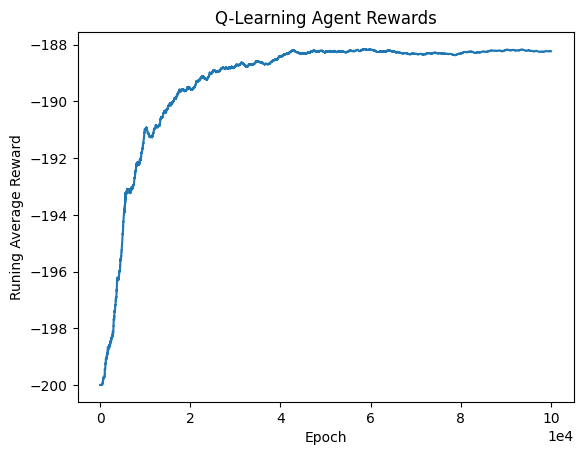

In [71]:
def evaluate_agent(agent,env,eval_episodes = 1000):
    """ 
    agent: Moutain_Agent; agent to be evaluated,
    env: gym.Env; environmet to be evaluated in,
    eval_episodes: int; number of episodes to evaluate for
    """
    solved = 0
    total =0

    for _ in tqdm(range(eval_episodes)):
        obs,_ = env.reset()
        obs = translate_obs(obs)
        done = False
        truncated = False


        while not(done or truncated):
            action = agent.greedy_act(obs)
            obs, reward,done,truncated, _ = env.step(action)
            obs = translate_obs(obs)
            if done:
                solved +=1
        
        total+=1



    return solved/total

solved = evaluate_agent(agent,env)

print(f'Percentage of evaluation episodes solved = {solved*100}%')

running_average = []
s = 0

for i, r in enumerate(rewards):
    s += (1/(i+1))*(r-s)
    running_average.append(s)

plt.xlabel('Epoch')
plt.ylabel('Runing Average Reward')
plt.ticklabel_format(style='sci', axis='x', scilimits=(4,4))
plt.title('Q-Learning Agent Rewards')
plt.plot(running_average)
plt.show()